# Estimating forest-based sequestration as a proxy to downscale LULUCF sequestration from IMAGE scenario
## On a test data

Description:  
The script prepares a method to estimate forest sequestration as a proxy to downscale gross sequestration from macro-region to country-level. Western Africa region (WAF) and the Democratic Republic of Congo (COD) are the study cases for the analysis.  

More explanation, if needed:  
`LULUCF downscaling is based on forest area changes.`
It comes from IMAGE model assumptions that deforestation and forest growth are the main drivers for LULUCF emissions. Forest area changes are recorded at each time step (from 2005 to 2100) by calculating the difference of the probability of forest occurrence between two years. 

- The difference of the probability is done on grid-by-grid basis
- When the difference is negative, it is considered as forest lost (or deforestation)
- When the difference is positive, it is considered as forest growth (herein called forest added)

`After getting the timeseries of forest changes, forest-based sequestration will be estimated.`
Gross emissions are downscaled based on the country share of forest lost relative to the lost at the macro-region level. 

Sequestration is downscaled based on the country share of forest sequestration relative to that at the macro-region level. Forest sequestration is estimated at every ages of growing and living forests based on the age-relevant sequestration rate. 

At every year, the age of new forest is determined then its sequestration at the given age is calculated. We only consider living forests as the input to estimate forest-based sequestration, so whenever there is a forest lost happening along the period of 2005 - 2100 in the same area as the occurrence of forest added, we use the forest lost to factor the forest added in the prior years. 

Sequestration rate at different forest ages is constructed as follows:
- In the first few years (20 - 25 years), forest sequesters carbon gradually until it reaches maximum at age 20 or 25 years 
- Forest will keep sequestering at the maximum rate for the next 60 - 100 years. Maximum seq rate and this "stable" period may vary depending on forest ecosystem.
- In the last few years when trees are getting older, forest deteriorates its seq rate until it reaches the minimum. This period goes for 25 - 30 years

Datasets:
- Model: `IMAGE`  
- Scenario: `SSP1_SPA0_19I_LIRE_LB`  
- Period: 2005 - 2100, with a 5-years time-step

Variable | Data source  
:--- | :-------  
Land distribution map | `GLANDCOVER_30MIN.NC`
Cell size (to convert the distribution map to area in km2) | `GAREA_30M.asc`
World border | `TM_WORLD_BORDERS-0`
Regional emission profile | `SSP1_SPA0_19I_LIRE_LB.xlsx`; release June 2021  

In [5]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import copy

# geospatial data wraggling
import geopandas as gpd
import rioxarray

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline

# Importing dataset

In [6]:
# to get directory to the data files in git
# pre-requisite: git folder should already be downloaded

def get_data_path(give_additional_path=None):
    # when the git is sitting in /Users/user_name
    if give_additional_path==None:
        my_path = os.path.join(os.path.expanduser('~'), "1o5_pathways_land_use", "data")
        
    # when the git is sitting in /Users/user_name/Documents/more/file/directory/...
    else:
        my_path = os.path.join(os.path.expanduser('~') + give_additional_path)
    
    return my_path

In [7]:
my_data_path = get_data_path()

In [8]:
# image dataset
image_file = "/IMAGE_SSPs/SSP1s_july2021/SSP1_SPA0_19I_LIRE_LB/GLANDCOVER_30MIN.NC"

df_19 = xr.open_dataset(my_data_path+image_file)
df_19 = df_19.rio.write_crs(4326)

In [9]:
# select land cover variable
glandcov_19 = df_19.GLANDCOVER_30MIN

# convert the current datetime type to only year type
glandcov_19["time"] = pd.DatetimeIndex(glandcov_19.time).year

In [10]:
# world border
b_file = "/IMAGE_SSPs/TM_WORLD_BORDERS-0"

regions = gpd.read_file(my_data_path+b_file)

In [49]:
# import garea, cell size
garea_file = "/IMAGE_SSPs/GAREA_30M.asc"

area = (rioxarray.open_rasterio(my_data_path+garea_file))
area_input = area.rio.write_crs(4326)

# Mask forest ratio gridded data to COD borders
- glandcov_19 is a data array containing forest distribution map. It represents forest in probability values. The values are ranging between 0 - 1, with 1 referring to a grid being 100% covered by forest. The values are the result from IMAGE model runs for the years between 1970 and 2100.
- masking glandcov_19 to COD borders using `land_dist` will get forest probability values for COD
- mask_area gives the area of each cell masked into country borders. the area of each cell can be used to convert forest probability to forest area

def land_dist

Parameter | Definition  
:--- | :-------  
ncdf_input | Data-array or N-dimensional array containing forest probability values (or probability values for other land use types)
land_type | String. The variable name of the relevant land use type (i.e. forest) as mapped in the input data-array
date | Year type, int. The year of which forest probability wants to be evaluated
reg_name | GeoDataFrame containing the border of a given country/region    

def mask_area

Parameter | Definition  
:--- | :-------  
area_df | Raster, data-array, or N-dimensional array containing the area of each cell with the same coordinate system as the input given to ncdf_input parameter
reg_name | GeoDataFrame containing the border of a given country/region  

In [12]:
cod_border = regions[regions.ISO3 == "COD"]

In [13]:
# function to mask forest distribution area to COD borders
def land_dist(ncdf, land_type, reg_name, **kwargs):
    dist_df = ncdf.sel(NGLNDCOV = land_type, **kwargs)
    
    reg = reg_name
    g_reg = reg.geometry
    
    clipped_dist = dist_df.rio.clip(g_reg, dist_df.rio.crs)
    
    return clipped_dist

In [14]:
# function to mask land area to COD borders
def mask_area(area_df, reg_name):
    g_reg = reg_name.geometry
    area_clip = area_df.rio.clip(g_reg, crs=area_df.rio.crs)
    area_tidy = area_clip.rename({'y': 'lat', 'x': 'lon'})
    
    return area_tidy

# Calculate the changes in forest ratio at every year
- Calculated at grid-by-grid basis within a given country/region border
- Changes at a given year n *($\delta \Delta$f(year=n))* is a difference between forest ratio at year n *(f(n))* and at year n-5 *f((n-5))*. For example, forest changes in 2010 is a difference between forest ratio in year 2010 and 2005

In [15]:
# changes in forest ratio in COD with time dimension
cod_forest_diff = (
    land_dist(ncdf=glandcov_19, land_type=b'forest                                            ', reg_name=cod_border)
    .sel(time=slice(2005, 2100))
    .diff("time")
)

In [16]:
cod_forest_diff.sel(time=2050)


<xarray.DataArray 'GLANDCOVER_30MIN' (lat: 38, lon: 38)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.        ,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.        ,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.        ,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.08327129,        nan,
               nan]], dtype=float32)
Coordinates:
  * lat          (lat) float64 5.25 4.75 4.25 3.75 ... -12.25 -12.75 -13.25
  * lon          (lon) float64 12.25 12.75 13.25 13.75 ... 29.75 30.25 30.75
    NGLNDCOV     |S50 b'forest                                            '
    time         int64 2050
    spatial_ref  int64 0

# Estimating forest-based sequestration with a test data
- The real data for COD contains 38 x 38 grids (latitude x longitude). A test data is a subset of the real data with 2 x 2 grids. It contains forest probability values at each grid.
- Period = 2010 - 2100 (with a 5-years time-step, so data length = 19)
- At every year, a function will evaluate whether there's forest lost or not in a given grid. If there's a forest lost event, the amount of forest lost is distributed across the years prior to the event to adjust the forest added in the prior years. We're still working with forest probability at every grids here, then the probability is converted to area.
- At every year, the total forest area from all the grids is calculated
- At every year, total forest area is multiplied with sequestration rate at the relevant age. Sequestration rate is in a form of pd.Series where the index is forest age and the values are the rate
- The end result is a timeseries of forest-based sequestration in 2010 - 2100

In [17]:
# test data with 2 x 2 grids
# period = 2010 - 2100
cod_test_data = cod_forest_diff.isel(lat=slice(36, 38), lon=[35, 0])

This kernel is a pd.Series or an np.array of sequestration at different forest ages. The length of the kernel is the same as the length of the data array containing changes in forest probability. The time-step of the kernel is also the same as the time-step of the data array. The kernel consists of:
- Phase-in period: (2 steps x 5 steps) 10 years, seq rate increases from 0 - 0.5
- Stable period: (15 x 5) 75 years, max seq rate at 1
- Phase-out period: (2 x 5) 10 years, seq rate decreases from 0.5 - 0

In [18]:
# create a kernel with seq rate, length = 19, to be made as a function
phase_in = [0, 0.5]  
saturated = [1] * 15 
phase_out = [0.5, 0]

kernel = np.array([*phase_in, *saturated, *phase_out])

In [19]:
# grid area in COD
cod_area = mask_area(area_df=area_to_use, reg_name=cod_border)

In [20]:
# keep this code for now
# save forest_sum to csv
# path_for_excel=os.path.join(os.path.expanduser('~'), "Downloads", f"{give_excel_name}.xlsx")

# with pd.ExcelWriter(path_for_excel) as writer:
    # for x in range(len(forest_sum)):
        # pd.Series(forest_sum[x], index=years).to_excel(writer, sheet_name=f"{years[x]}") 

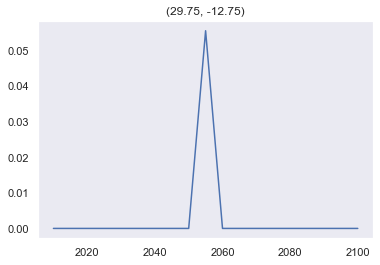

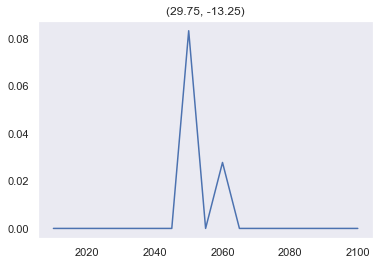

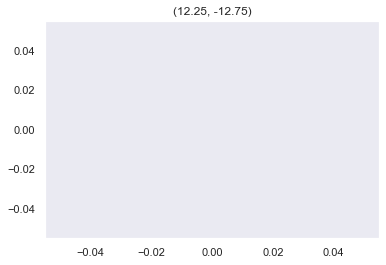

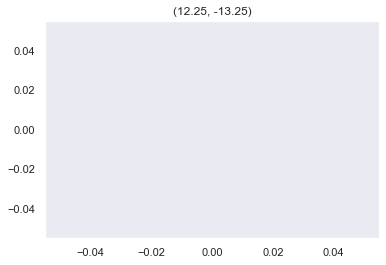

In [21]:
import itertools
for i, j in itertools.product(cod_test_data.lon.values, cod_test_data.lat.values):
    plt.figure()
    plt.plot(pd.Series(cod_test_data.sel(lon=i, lat=j), index=cod_test_data.time.values))
    plt.title(f"{i, j}")

Forest sequestration is estimated using estimate_seq function following the above pipeline. The function takes the following as an input:  

Parameter | Definition  
:--- | :-------  
input_forest_array | N-dimensional array containing the changes in forest probability between two years
input_area_array | Raster, data-array, or N-dimensional array containing the area of each cell with the same coordinate system as the input given to forest_diff parameter, already masked to a country/region level
seq_rate_ls | A 1-D array, list, or sequence containing sequestration rate at different forest age with the same length as the forest_diff parameter

In [61]:
def estimate_seq_2(input_ncdf, give_land_type, reg_boundary, area_to_use, seq_rate_ls):
    forest_diff = (
        land_dist(ncdf=input_ncdf, land_type=give_land_type, reg_name=reg_boundary)
        .sel(time=slice(2005, 2100))
        .diff("time")
    )
    
    country_area = mask_area(area_df=area_to_use, reg_name=reg_boundary)

    adjusted_data = forest_diff.copy().clip(min=0)

    forest_added_sum = []
    for yr_now in range(len(forest_diff)): 
        forest_diff_current_year = forest_diff.isel(time=yr_now)
        
        forest_lost_cells = forest_diff_current_year < 0
        if forest_lost_cells.any():
            adjusted_until_now = adjusted_data.isel(time=slice(0, yr_now))
            sum_added = adjusted_until_now.sum("time")

            cells_to_update = forest_lost_cells & (abs(forest_diff_current_year) <= abs(sum_added))
            if cells_to_update.any():
                new_adjusted_data = adjusted_until_now + xr.where(cells_to_update, (adjusted_until_now / sum_added * forest_diff_current_year), 0)

                adjusted_data = xr.concat([new_adjusted_data, adjusted_data.isel(time=slice(yr_now, None))], dim="time")
        
        adjusted_area = adjusted_data * country_area
        
        unit_converter = 100
        adjusted_area_ha = adjusted_area * unit_converter
        
        forest_series = adjusted_area_ha.isel(time=slice(0, yr_now), band=0).sum(["lat", "lon"]).to_series()
        years = forest_diff.isel(time=slice(yr_now, -1)).time.values
        da_zeros = [0] * len(years)
        end_result = forest_series.append(pd.Series(data=da_zeros, dtype="float32"), ignore_index=True)
        forest_added_sum.append(end_result)
        
    seq_ts = []
    
    for yrs in range(len(forest_added_sum)):
        forest_current = forest_added_sum[yrs]
        interim = []
        for x in range(len(forest_current)):
            seq = forest_current[x] * seq_rate_ls[yrs-x]
            interim.append(np.sum(seq))
        seq_ts.append(np.sum(interim))
        
    years_index = forest_diff.time.values
    seq_df = pd.DataFrame({"Forest seq" : seq_ts}, index=years_index)
    
    return seq_df

In [31]:
def estimate_seq(input_forest_array, input_area_array, seq_rate_ls):
    adjusted_data = input_forest_array.copy().clip(min=0)

    forest_added_sum = []
    for yr_now in range(len(input_forest_array)): 
        forest_diff_current_year = input_forest_array.isel(time=yr_now)
        
        forest_lost_cells = forest_diff_current_year < 0
        if forest_lost_cells.any():
            adjusted_until_now = adjusted_data.isel(time=slice(0, yr_now))
            sum_added = adjusted_until_now.sum("time")

            cells_to_update = forest_lost_cells & (abs(forest_diff_current_year) <= abs(sum_added))
            if cells_to_update.any():
                new_adjusted_data = adjusted_until_now + xr.where(cells_to_update, (adjusted_until_now / sum_added * forest_diff_current_year), 0)

                adjusted_data = xr.concat([new_adjusted_data, adjusted_data.isel(time=slice(yr_now, None))], dim="time")
        
        adjusted_area = adjusted_data * input_area_array
        
        unit_converter = 100
        adjusted_area_ha = adjusted_area * unit_converter
        
        forest_series = adjusted_area_ha.isel(time=slice(0, yr_now), band=0).sum(["lat", "lon"]).to_series()
        years = input_forest_array.isel(time=slice(yr_now, -1)).time.values
        da_zeros = [0] * len(years)
        end_result = forest_series.append(pd.Series(data=da_zeros, dtype="float32"), ignore_index=True)
        forest_added_sum.append(end_result)
        
    seq_ts = []
    
    for yrs in range(len(forest_added_sum)):
        forest_current = forest_added_sum[yrs]
        interim = []
        for x in range(len(forest_current)):
            seq = forest_current[x] * seq_rate_ls[yrs-x]
            interim.append(np.sum(seq))
        seq_ts.append(np.sum(interim))
        
    years_index = input_forest_array.time.values
    seq_series = pd.Series(data=seq_ts, index=years_index)
    
    return seq_series

In [23]:
changes_unit_km2 = estimate_seq(input_forest_array=cod_test_data, input_area_array=cod_area)

In [29]:
changes_unit_ha = estimate_seq(input_forest_array=cod_test_data, input_area_array=cod_area)

In [30]:
changes_unit_ha[10]

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
5         0.000000
6         0.000000
7         0.000000
8     24961.404297
9     16686.164062
10        0.000000
11        0.000000
12        0.000000
13        0.000000
14        0.000000
15        0.000000
16        0.000000
17        0.000000
dtype: float32

In [32]:
seq_co2_ha = estimate_seq(input_forest_array=cod_test_data, input_area_array=cod_area, seq_rate_ls=kernel)

<AxesSubplot:>

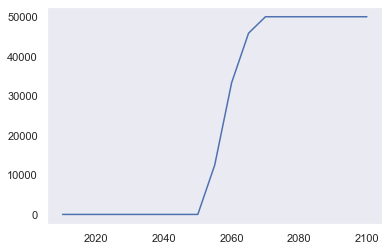

In [34]:
seq_co2_ha.plot()

In [34]:
test_data_seq = estimate_seq(input_forest_array=cod_test_data, input_area_array=cod_area, seq_rate_ls=kernel)

In [35]:
test_data_seq

2010      0.000000
2015      0.000000
2020      0.000000
2025      0.000000
2030      0.000000
2035      0.000000
2040      0.000000
2045      0.000000
2050      0.000000
2055    124.807022
2060    333.044861
2065    458.116245
2070    499.756824
2075    499.756797
2080    499.756797
2085    499.756797
2090    499.756797
2095    499.756797
2100    499.756797
dtype: float64

<AxesSubplot:>

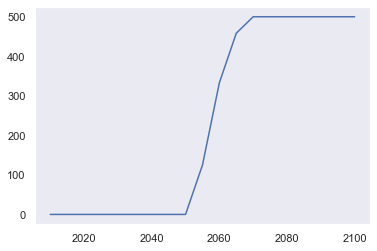

In [36]:
test_data_seq.plot()

`Test data with multiple negative values`
- If there's a forest lost in the beginning of the iteration, adjust forest added to zero
- If there's a forest lost that is larger than the total forest added, ignore the calculation of adjusting forest added and return negative value to zero
- If there's a forest added in the beginning of the iteration, adjust forest added or keep the same value depending on the condition on forest lost

In [29]:
# change first year to negative and see if algorithm will put it to zero
cod_test_data.loc[2010, -13.25, 29.75] = - 0.01

# change the first year to positive
cod_test_data.loc[2010, -12.75, 29.75] = 0.08

# change sometime in the future to a forest lost bigger than the sum forest added
cod_test_data.loc[2085, -12.75, 29.75] = - 0.2

In [30]:
try_seq_2 = estimate_seq(input_forest_array=cod_test_data, input_area_array=cod_area, seq_rate_ls=kernel)

In [31]:
try_seq_2

2010      0.000000
2015    120.139999
2020    240.279999
2025    240.279999
2030    240.279999
2035    240.279999
2040    240.279999
2045    240.279999
2050    240.279999
2055    365.087021
2060    573.324860
2065    698.396244
2070    740.036823
2075    740.036796
2080    740.036796
2085    740.036796
2090    740.036796
2095    619.896797
2100    499.756797
dtype: float64

# Estimating forest-based sequestration with real data

In [35]:
# function to create the kernel shape
def make_kernel(saturation, phase_in, phase_out, max_seq_rate):
    return np.r_[
        0:max_seq_rate:phase_in*1j,
        max_seq_rate:max_seq_rate:saturation*1j,
        max_seq_rate:0:phase_out*(-1j)
    ]

In [36]:
def convert_c(seq_in_c, **kernel_parameters):
    seq_in_co2 = seq_in_c * 3.67
    kernel = make_kernel(max_seq_rate=seq_in_co2, **kernel_parameters)#[M//2:-M//20+1]
    return kernel

In [37]:
trop_kernel = convert_c(seq_in_c=3.1, saturation=10, phase_in=5, phase_out=4)

In [38]:
len(trop_kernel)

19

In [39]:
cod_forest_seq = estimate_seq(input_forest_array=cod_forest_diff, input_area_array=cod_area, seq_rate_ls=trop_kernel)

In [40]:
len(cod_forest_seq)

19

<AxesSubplot:>

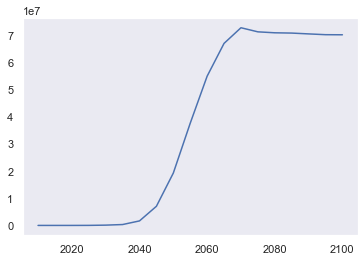

In [42]:
# unit in t CO2 / ha
cod_forest_seq.plot()

In [50]:
cod_forest_seq_2 = estimate_seq_2(input_ncdf=glandcov_19, give_land_type=b'forest                                            ', 
                                  reg_boundary=cod_border, area_to_use=area_input, seq_rate_ls=trop_kernel)

In [145]:
kernel

array([0. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 0.5, 0. ])

In [43]:
test_kernel = estimate_seq(input_forest_array=cod_forest_diff, input_area_array=cod_area, seq_rate_ls=kernel)

<AxesSubplot:>

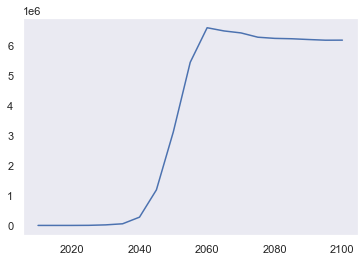

In [44]:
# unit = t CO2/ha 
test_kernel.plot()

---
# Testing area

In [74]:
def calc_downscaling_weights(forest_ch_input, variable_name):
    # data preparation
    df_country = pd.DataFrame() 
    country_list = [] 
    for names in forest_ch_input.keys(): # forest changes input should be in dict
        df_country = df_country.append(forest_ch_input[names][variable_name], ignore_index=True) 
        
        country_list.append(names) # appending the country names
        df_country.index = country_list
        
    # calculate the weights
    df_weights = copy.deepcopy(df_country)
    for countries in df_country.index:
        for years in df_country.columns:
            if years == df_country.columns[0]:
                df_country.loc[countries][years] = 0
            else:
                df_weights.loc[countries][years] = df_country.loc[countries][years]/df_country[years].sum()
            
    return df_weights

In [46]:
cam_cod = [120, 180]
# 654 is not within the bounds

# subset WAF boundary
waf_reg= regions[regions.UN.isin(cam_cod)]

In [47]:
waf_reg

FIPS ISO2 ISO3   UN                              NAME    AREA   POP2005  \
27   CG   CD  COD  180  Democratic Republic of the Congo  226705  58740547   
34   CM   CM  CMR  120                          Cameroon   46540  17795149   

    REGION  SUBREGION     LON    LAT   _count_2    _sum_2  \
27       2         17  23.654 -2.876  4256637.0  242116.0   
34       2         17  12.277  5.133   849519.0   37326.0   

                                             geometry  
27  MULTIPOLYGON (((12.95305 -5.87611, 12.93361 -5...  
34  MULTIPOLYGON (((9.68722 3.57472, 9.62611 3.551...

In [62]:
forest_seq_waf = {}
for country in waf_reg.ISO3:
    forest_seq_waf[country] = estimate_seq_2(input_ncdf=glandcov_19, give_land_type=b'forest                                            ', 
                                             reg_boundary=waf_reg[waf_reg.ISO3 == country], area_to_use=area_input, seq_rate_ls=trop_kernel)

In [64]:
forest_seq_waf["COD"]

Forest seq
2010  0.000000e+00
2015  8.093336e+00
2020  1.596993e+01
2025  1.574470e+04
2030  1.027139e+05
2035  3.232170e+05
2040  1.665149e+06
2045  7.056284e+06
2050  1.931663e+07
2055  3.769870e+07
2060  5.505114e+07
2065  6.714660e+07
2070  7.291974e+07
2075  7.140909e+07
2080  7.105682e+07
2085  7.095166e+07
2090  7.064753e+07
2095  7.035761e+07
2100  7.032092e+07

In [75]:
ratio_df = calc_downscaling_weights(forest_ch_input=forest_seq_waf, variable_name="Forest seq")

In [76]:
ratio_df.columns[0]

2010

In [77]:
ratio_df

2010  2015      2020      2025      2030      2035      2040      2045  \
COD   0.0   1.0  0.996751  0.957416  0.986548  0.993542  0.998321  0.986811   
CMR   0.0   0.0  0.003249  0.042584  0.013452  0.006458  0.001679  0.013189   

         2050      2055      2060      2065      2070      2075      2080  \
COD  0.924157  0.882448  0.866221  0.850668  0.842157  0.841689  0.841029   
CMR  0.075843  0.117552  0.133779  0.149332  0.157843  0.158311  0.158971   

         2085      2090      2095      2100  
COD  0.841102  0.842438  0.841938  0.841869  
CMR  0.158898  0.157562  0.158062  0.158131